# WLS - Code Examples Part 2

## A Note on Estimating Weights When True Variance is Unknown

In experimental sciences, you may know the uncertainty ($\sigma_i$) for each measurement from the specifications of your instruments or from repeated measurements. However, in many other fields, such as econometrics or the social sciences, the true error variances ($\sigma_i^2$) are not known. When you detect heteroscedasticity - for example, by seeing a "cone" or "megaphone" shape in a plot of your model's residuals - you cannot simply ignore it.

In these situations, you must estimate the weights from the data itself. This data-driven approach is often called **Feasible Generalized Least Squares (FGLS)** or, more specifically for our case, two-stage WLS. The process provides a robust way to obtain more efficient and reliable parameter estimates.

### The Multi-Step Procedure for Estimating Weights for Linear Problem

Here is a common and practical procedure to estimate the weights and perform a WLS regression.

1.  **Perform an Initial OLS Regression:**
    *   First, run a standard Ordinary Least Squares (OLS) regression on your data: $y = f(x, \beta) + \epsilon$.
    *   OLS gives unbiased and consistent parameter estimates even when heteroscedasticity is present, so it serves as a valid starting point.

2.  **Analyze the Residuals to Model the Variance:**
    *   Obtain the residuals ($e_i = y_i - \hat{y}_i$) from the OLS fit.
    *   Since raw squared residuals ($e_i^2$) can be very noisy estimates of variance, it is better to model the variance as a function of the predictors or the fitted values.
    *   To do this, you regress a transformation of the residuals on the variable you believe is driving the heteroscedasticity. A common choice is to use the absolute residuals ($|e_i|$) as a proxy for the standard deviation ($\sigma_i$) or the squared residuals ($e_i^2$) as a proxy for the variance ($\sigma_i^2$). Using absolute residuals is often more robust to outliers.

3.  **Calculate the Weights:**
    *   The fitted values from the regression in Step 2 give you the estimated standard deviations ($\hat{\sigma}_i$) or variances ($\hat{\sigma}_i^2$) for each observation.
    *   You then calculate the weight for each observation as the inverse of the estimated variance: $w_i = 1 / \hat{\sigma}_i^2$.

4.  **Perform the Final WLS Regression:**
    *   Rerun the original regression from Step 1, but this time apply the calculated weights ($w_i$) to each observation. This final fit is the Weighted Least Squares regression. The resulting parameter estimates will be more efficient, and their standard errors will be more reliable.

### Example: Modeling Household Spending

Let's walk through a conceptual example to make this procedure clear.

Imagine you are a data scientist modeling a household's annual spending ($y$) based on its annual income ($x$). Your hypothesis is that $y = \beta_0 + \beta_1 x$.

*   **Step 1: Initial OLS Fit**
    You collect data from 1,000 households and run an OLS regression. You get initial estimates for $\beta_0$ and $\beta_1$.

*   **Step 2: Detect Heteroscedasticity and Model Variance**
    You plot the residuals ($e_i$) against the income ($x_i$). The plot looks like this:

    You observe a classic "megaphone" shape: the spread of the residuals is much smaller for low-income households and much larger for high-income households. This indicates that variance is not constant.

    You decide to model this variance. A reasonable assumption is that the standard deviation of spending is proportional to income. To estimate this relationship, you regress the absolute value of the residuals on income:
    $$|e_i| = \gamma_0 + \gamma_1 \cdot \text{income}_i$$

*   **Step 3: Calculate Weights**
    From the regression in Step 2, you get the predicted (fitted) values for the absolute residuals, let's call them $\hat{e}_{abs_i}$. These fitted values are your estimates for the standard deviation of each observation, so $\hat{\sigma}_i = \hat{e}_{abs_i}$.

    The estimated variance for each observation is therefore $\hat{\sigma}_i^2 = (\hat{e}_{abs_i})^2$.

    Now, you can calculate the weight for each household in your dataset:
    $$w_i = \frac{1}{\hat{\sigma}_i^2} = \frac{1}{(\hat{e}_{abs_i})^2}$$
    High-income households, which had large residuals, will get smaller weights. Low-income households, which had small residuals, will get larger weights.

*   **Step 4: Perform Final WLS Regression**
    Finally, you rerun your original model (`Spending ~ Income`) but instruct your statistical software to use the weights ($w_i$) you just calculated. The new WLS model will minimize the weighted sum of squared residuals. The resulting estimates for the effect of income on spending will be more efficient, and the confidence intervals will be more accurate than what the initial OLS model provided.

### Why We Don't Use a Single SER

The **Standard Error of the Regression (SER)**, which is the square root of the estimated error variance, is an estimate of a single, constant $\sigma$. The formula for SER is:

$$\hat{\sigma} = \sqrt{\frac{\sum_{i=1}^{n} e_i^2}{n-k}}$$

where:
* $e_i$ is the residual for observation $i$.
* $n$ is the number of observations.
* $k$ is the number of parameters estimated in the model.

Using this single value, $\hat{\sigma}$, would mean we assume the error variance is constant across all observations—the definition of **homoscedasticity**. If we were to use this value to calculate weights, every observation would get the same weight, $w_i = 1/\hat{\sigma}^2$. This would turn the Weighted Least Squares (WLS) regression back into a standard Ordinary Least Squares (OLS) regression, which completely defeats the purpose of trying to address heteroscedasticity.

## Additional Materials

* https://www.aptech.com/blog/using-feasible-generalized-least-squares-to-improve-estimates/

## Example 1

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# --- 1. Generate Synthetic Data with Heteroscedasticity ---

# Set a seed for reproducibility
np.random.seed(42)

# Generate 500 data points for household income (in thousands of dollars)
# Income ranges from $20k to $150k
n_samples = 500
income = np.linspace(20, 150, n_samples)

# Define the true relationship between income and spending
# True intercept = 5 (i.e., $5k base spending)
# True slope = 0.3 (i.e., 30% of income is spent)
true_intercept = 5
true_slope = 0.3
true_spending = true_intercept + true_slope * income

# Introduce heteroscedastic noise
# The error's standard deviation increases with income
# This is the key step to create heteroscedasticity
error_std_dev = 0.1 * income  # Std. dev. is 10% of income
noise = np.random.normal(0, error_std_dev, n_samples)

# Calculate the final, observed spending
observed_spending = true_spending + noise

# Add a constant (for the intercept) to our predictor variable for statsmodels
X = sm.add_constant(income)

In [19]:
print(X[0:20])


[[ 1.         20.        ]
 [ 1.         20.26052104]
 [ 1.         20.52104208]
 [ 1.         20.78156313]
 [ 1.         21.04208417]
 [ 1.         21.30260521]
 [ 1.         21.56312625]
 [ 1.         21.82364729]
 [ 1.         22.08416834]
 [ 1.         22.34468938]
 [ 1.         22.60521042]
 [ 1.         22.86573146]
 [ 1.         23.12625251]
 [ 1.         23.38677355]
 [ 1.         23.64729459]
 [ 1.         23.90781563]
 [ 1.         24.16833667]
 [ 1.         24.42885772]
 [ 1.         24.68937876]
 [ 1.         24.9498998 ]]


### The Intercept Term in Linear Regression 

In a linear regression model, the relationship between a dependent variable ($y$) and an independent variable ($x$) is expressed as:

$y = \beta_0 + \beta_1x + \epsilon$

Here, $\beta_0$ is the **intercept** and $\beta_1$ is the slope. The intercept ($\beta_0$) represents the expected value of $y$ when $x$ is zero. In the context of our code, it represents the baseline spending when income is zero. The `statsmodels` library, by default, expects you to explicitly include this intercept term as a column of ones in your predictor matrix. This is because it treats the linear model as:

$y = \beta_0 \cdot 1 + \beta_1 \cdot x + \epsilon$

By adding a constant column of ones to your predictor variables, you're creating a matrix where the first column is a representation of the constant term (1), allowing the model to estimate the coefficient $\beta_0$.

### How `sm.add_constant` Works

The `sm.add_constant(income)` function takes the `income` array and adds a new column of ones to the beginning of it.

* **Original `income` array:**
    `[20, 20.26, ..., 150]`

* **After `sm.add_constant(income)`:**
    `[[1.0, 20], [1.0, 20.26], ..., [1.0, 150]]`
    

This modified array, named `X`, now has two columns. The first column (all ones) is used to calculate the intercept, while the second column (`income`) is used to calculate the slope. This is why the in the comment to the code we mentioned "(for the intercept)"; it's explicitly explaining the purpose of adding the constant column.

### Perform an Initial OLS Regression

--- Step 1 & 2: Performing OLS and Analyzing Residuals ---

OLS Parameter Estimates:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2010      1.036      5.019      0.000       3.165       7.237
x1             0.2993      0.011     26.845      0.000       0.277       0.321
Residual Sum of Squares (RSS): 43755.13
Root Mean Squared Error (RMSE): 9.37
Standard Error of the Regression (SER): 9.37
R-squared: 0.5914
Adjusted R-squared: 0.5905


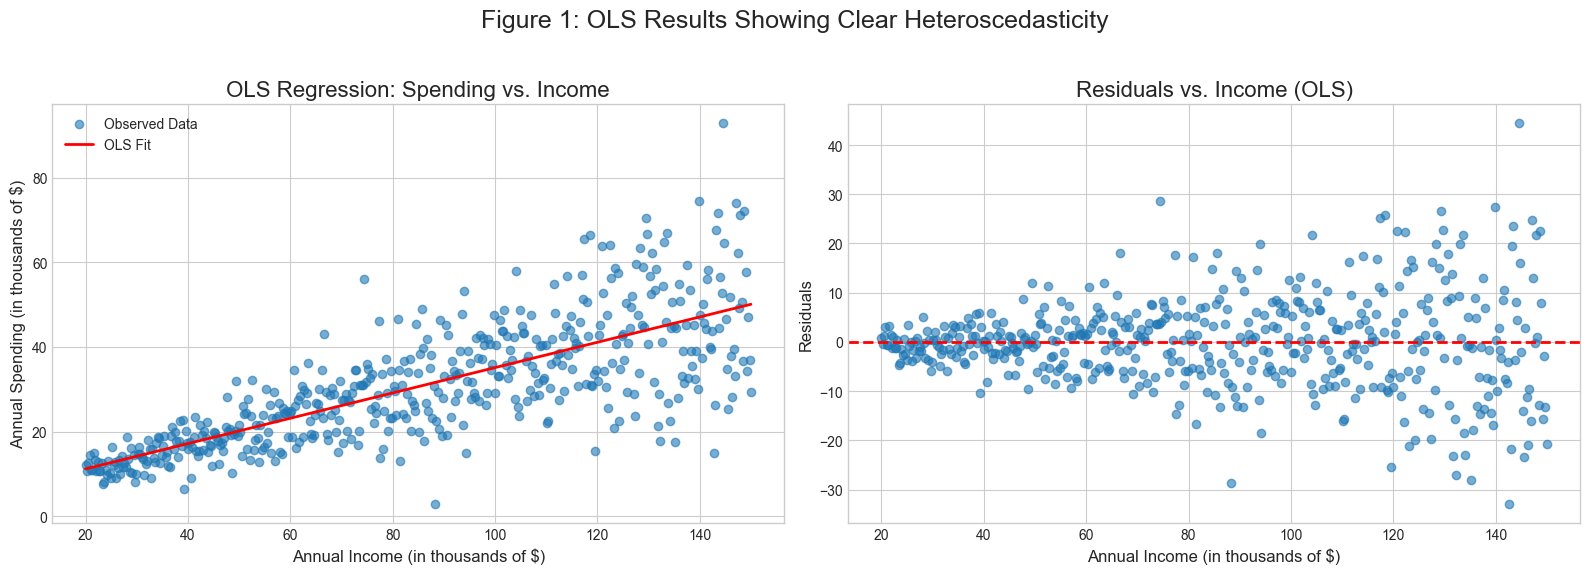

In [ ]:
# --- 2. Perform an Initial OLS Regression ---

print("--- Step 1 & 2: Performing OLS and Analyzing Residuals ---")
# Fit the OLS model
ols_model = sm.OLS(observed_spending, X)
ols_results = ols_model.fit()

# Get the OLS predictions and residuals
ols_predictions = ols_results.predict(X)
ols_residuals = ols_results.resid

print("\nOLS Parameter Estimates:")
print(ols_results.summary().tables[1])

# Access the metrics directly from the ols_results object
rss = ols_results.ssr 
rmse = np.sqrt(ols_results.mse_resid) 
ser = np.sqrt(ols_results.scale)
r_squared = ols_results.rsquared
adjusted_r_squared = ols_results.rsquared_adj

print(f"Residual Sum of Squares (RSS): {rss:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Standard Error of the Regression (SER): {ser:.2f}")
print(f"R-squared: {r_squared:.4f}")
print(f"Adjusted R-squared: {adjusted_r_squared:.4f}")

In [ ]:
# --- Plot OLS Results and Residuals ---

plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: OLS Fit
ax1.scatter(income, observed_spending, alpha=0.6, label='Observed Data')
ax1.plot(income, ols_predictions, color='red', linewidth=2, label='OLS Fit')
ax1.set_title('OLS Regression: Spending vs. Income', fontsize=16)
ax1.set_xlabel('Annual Income (in thousands of $)', fontsize=12)
ax1.set_ylabel('Annual Spending (in thousands of $)', fontsize=12)
ax1.legend()
ax1.grid(True)

# Plot 2: Residual Plot to show heteroscedasticity
ax2.scatter(income, ols_residuals, alpha=0.6)
ax2.axhline(0, color='red', linestyle='--', linewidth=2)
ax2.set_title('Residuals vs. Income (OLS)', fontsize=16)
ax2.set_xlabel('Annual Income (in thousands of $)', fontsize=12)
ax2.set_ylabel('Residuals', fontsize=12)
ax2.grid(True)

plt.suptitle("Figure 1: OLS Results Showing Clear Heteroscedasticity", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Output Analysis

The parameters `t`, `P>|t|`, and `[0.025 0.975]` are essential for **hypothesis testing** and **confidence interval estimation**. They help us determine if the relationship between our independent and dependent variables is statistically significant.

### The t-statistic ($t$)

The **t-statistic** measures how many standard deviations the estimated coefficient is from zero. In other words, it quantifies the evidence against the null hypothesis ($H_0$), which states that the true coefficient is zero (i.e., there is no relationship between the independent and dependent variables). A larger absolute value of $t$ indicates that the coefficient is less likely to be zero by chance.

$$t = \frac{\text{Estimated Coefficient} - 0}{\text{Standard Error of the Coefficient}}$$

In our output:
* For the intercept $\beta_0$: $t = \frac{5.2010}{1.036} \approx 5.019$.
* For the slope coefficient $\beta_1$: $t = \frac{0.2993}{0.011} \approx 26.845$.

The very high $t$-statistic for income ($26.845$) strongly suggests that the slope is not zero, meaning there is a significant relationship between income and spending.

### The P-value ($P>|t|$)

The **P-value** is the probability of observing a $t$-statistic as extreme as, or more extreme than, the one calculated, assuming the null hypothesis is true. A small P-value provides strong evidence to **reject the null hypothesis**. The common threshold for significance is $\alpha = 0.05$. If our P-value is less than 0.05, we can conclude that the coefficient is statistically significant. 

In our output:
* For both the constant and income, the P-values are **0.000**.
* This means the probability of observing these coefficients if there were no real relationship is practically zero. You can confidently reject the null hypothesis and conclude that both the intercept and the effect of income on spending are statistically significant.

### The Confidence Interval ([0.025 0.975])

The **confidence interval** is a range of values that likely contains the true, unknown value of the coefficient. The `[0.025 0.975]` columns represent the **95% confidence interval**, meaning that if you were to repeat our sampling and analysis many times, 95% of the calculated confidence intervals would contain the true population parameter. The key takeaway is to see if this interval includes zero. If the interval does not contain zero, it is further evidence that the coefficient is statistically significant, consistent with a low P-value.

In our output:
* For the constant $\beta_0$: The 95% confidence interval is `[3.165, 7.237]`. Since this range does not contain zero, the intercept is statistically significant.
* For the income coefficient ($\beta_1$): The 95% confidence interval is `[0.277, 0.321]`. This range also does not contain zero. This confirms that the true effect of a $1k increase in income on spending is likely to be between a $277 and a $321 increase, and it's highly unlikely to be zero.

### Estimate Weights from OLS Residuals

In [21]:
# --- 3. Estimate Weights from OLS Residuals ---

print("\n--- Step 3: Estimating Weights from OLS Residuals ---")
# The variance seems proportional to income, so we model the absolute residuals vs. income.
# Using absolute residuals is often more robust.
abs_ols_residuals = np.abs(ols_residuals)

# Regress absolute residuals on income to estimate the standard deviation
# This is our variance model
variance_model = sm.OLS(abs_ols_residuals, X)
variance_results = variance_model.fit()

# The fitted values from this model are our estimated standard deviations
estimated_std_dev = variance_results.predict(X)

# The weights are the inverse of the estimated variance
estimated_variance = estimated_std_dev**2
weights = 1.0 / estimated_variance

print("Weights have been calculated based on the variance model.")


--- Step 3: Estimating Weights from OLS Residuals ---
Weights have been calculated based on the variance model.


In [22]:
print(weights[0:40])  # Display the first 40 weights for inspection

[0.7853452  0.75496637 0.72631672 0.69926747 0.67370159 0.64951257
 0.62660329 0.60488505 0.58427668 0.56470383 0.54609828 0.52839731
 0.51154322 0.49548285 0.48016711 0.46555068 0.45159163 0.43825111
 0.42549312 0.41328423 0.40159337 0.39039165 0.37965215 0.36934979
 0.35946116 0.3499644  0.34083908 0.33206607 0.32362748 0.31550651
 0.30768743 0.30015545 0.29289669 0.28589809 0.27914737 0.27263296
 0.26634395 0.26027007 0.25440162 0.24872943]


### Perform the Final WLS Regression


--- Step 4: Performing WLS Regression with Calculated Weights ---

WLS Parameter Estimates:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.5562      0.397     11.490      0.000       3.777       5.335
x1             0.3076      0.008     37.805      0.000       0.292       0.324
WLS Residual Sum of Squares (RSS): 43805.61
WLS Residual Sum of Squares (RSS): 816.31
WLS Root Mean Squared Error (RMSE): 1.28
WLS Standard Error of the Regression (SER): 1.28
WLS R-squared: 0.7416
WLS Adjusted R-squared: 0.7411


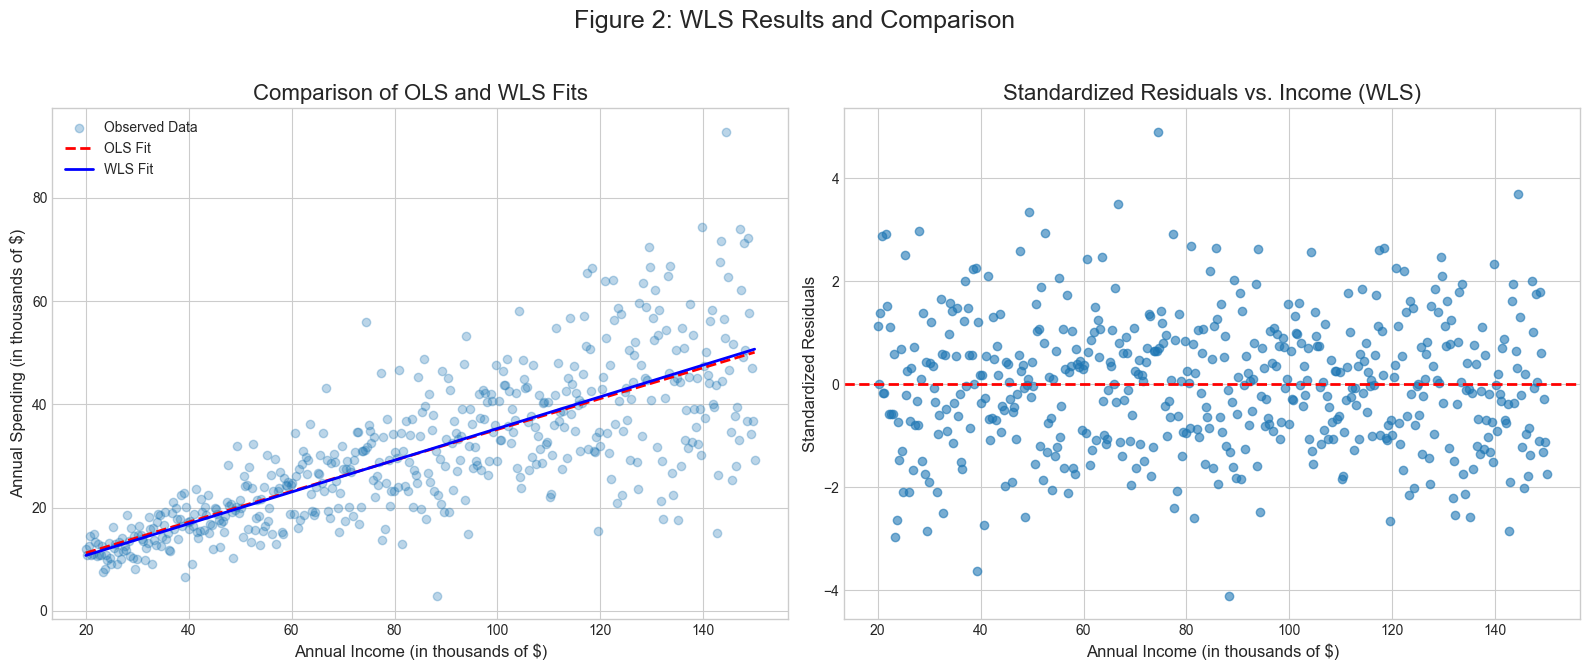

In [35]:
# --- 4. Perform the Final WLS Regression ---

print("\n--- Step 4: Performing WLS Regression with Calculated Weights ---")
# Fit the WLS model using the calculated weights
wls_model = sm.WLS(observed_spending, X, weights=weights)
wls_results = wls_model.fit()

# Get the WLS predictions
wls_predictions = wls_results.predict(X)

print("\nWLS Parameter Estimates:")
print(wls_results.summary().tables[1])

wls_residuals = wls_results.resid

# Calculate Residual Sum of Squares (RSS)
wls_rss_calc = np.sum(wls_residuals**2)
print(f"WLS Residual Sum of Squares (RSS): {wls_rss_calc:.2f}")

# Access the metrics directly from the wls_results object
wls_rss = wls_results.ssr
wls_rmse = np.sqrt(wls_results.mse_resid) 
wls_ser = np.sqrt(wls_results.scale)
wls_r_squared = wls_results.rsquared
wls_adjusted_r_squared = wls_results.rsquared_adj

print(f"WLS Residual Sum of Squares (RSS): {wls_rss:.2f}")
print(f"WLS Root Mean Squared Error (RMSE): {wls_rmse:.2f}")
print(f"WLS Standard Error of the Regression (SER): {wls_ser:.2f}")
print(f"WLS R-squared: {wls_r_squared:.4f}")
print(f"WLS Adjusted R-squared: {wls_adjusted_r_squared:.4f}")

# --- 5. Visualize and Compare OLS and WLS Results ---

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Comparison of OLS and WLS fits
ax1.scatter(income, observed_spending, alpha=0.3, label='Observed Data')
ax1.plot(income, ols_predictions, color='red', linestyle='--', linewidth=2, label='OLS Fit')
ax1.plot(income, wls_predictions, color='blue', linewidth=2, label='WLS Fit')
ax1.set_title('Comparison of OLS and WLS Fits', fontsize=16)
ax1.set_xlabel('Annual Income (in thousands of $)', fontsize=12)
ax1.set_ylabel('Annual Spending (in thousands of $)', fontsize=12)
ax1.legend()
ax1.grid(True)

# Plot 2: WLS Residuals (now should be homoscedastic)
# WLS residuals are weighted residuals, but it's more intuitive to plot standardized residuals
wls_standardized_residuals = wls_results.resid / np.sqrt(estimated_variance)
ax2.scatter(income, wls_standardized_residuals, alpha=0.6)
ax2.axhline(0, color='red', linestyle='--', linewidth=2)
ax2.set_title('Standardized Residuals vs. Income (WLS)', fontsize=16)
ax2.set_xlabel('Annual Income (in thousands of $)', fontsize=12)
ax2.set_ylabel('Standardized Residuals', fontsize=12)
ax2.grid(True)

plt.suptitle("Figure 2: WLS Results and Comparison", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

NOTE: Compare the results of WLS and OLS to see that WLS provided us with more accurate results.

### WLS standardized residuals

WLS standardized residuals are a modified version of the standard residuals from a weighted least squares regression. They are calculated by dividing each WLS residual by its corresponding estimated standard deviation, which accounts for the varying weights given to each observation.

**The Problem with OLS Residuals**

In ordinary least squares (OLS) regression, a key assumption is **homoscedasticity**, which means the variance of the errors is constant across all levels of the independent variable. When this assumption is violated (**heteroscedasticity**), the spread of the residuals is not uniform. A common visual sign is a "cone" or "megaphone" shape in a residual plot.

**The WLS Solution**

Weighted least squares (WLS) addresses heteroscedasticity by assigning a **weight** to each data point. Observations with smaller variance (more reliable data) are given higher weights, while observations with larger variance (less reliable data) are given lower weights. This effectively "squishes" the cone shape and gives a more accurate regression line.

**WLS Residuals vs. Standardized Residuals**

* **WLS Residuals**: These are the raw residuals from the WLS model. They represent the difference between the observed value and the predicted value for each data point. However, they still reflect the original, non-uniform variance. A plot of raw WLS residuals against the independent variable would still show a heteroscedastic pattern, which isn't useful for checking if the weighting was successful.

* **WLS Standardized Residuals**: To properly check if the WLS model has corrected for heteroscedasticity, we need to standardize the residuals. This is done by taking each WLS residual and dividing it by its estimated standard deviation. The formula is:

$$\text{Standardized Residual}_i = \frac{\text{WLS Residual}_i}{\sqrt{\text{Estimated Variance}_i}}$$

This process normalizes the residuals, so they should now have a constant variance and be randomly scattered around zero. Plotting these standardized residuals against the independent variable is the correct way to assess if the weighting scheme was effective. A successful WLS model will produce a standardized residual plot that looks like a random cloud of points with no discernible pattern.

## Example 2

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# --- 1. Generate Synthetic Data with Heteroscedasticity ---
# This part is identical to the previous example.

# Set a seed for reproducibility
np.random.seed(42)

# Generate 500 data points for household income (in thousands of dollars)
n_samples = 500
income = np.linspace(20, 150, n_samples)

# Define the true relationship between income and spending
true_intercept = 5
true_slope = 0.3

# The function we want to fit
def linear_model(x, intercept, slope):
    """A simple linear model function for curve_fit."""
    return intercept + slope * x

# Calculate the "true" spending based on the model
true_spending = linear_model(income, true_intercept, true_slope)

# Introduce heteroscedastic noise (error's standard deviation increases with income)
error_std_dev = 0.1 * income
noise = np.random.normal(0, error_std_dev, n_samples)

# Calculate the final, observed spending
observed_spending = true_spending + noise


--- Step 1 & 2: Performing Unweighted Fit (OLS) and Analyzing Residuals ---

OLS Parameter Estimates:
  Intercept: 5.2010 +/- 1.0362
  Slope:     0.2993 +/- 0.0111
Residual Sum of Squares (RSS): 43755.13
Root Mean Squared Error (RMSE): 9.35
Standard Error of the Residuals (SER): 9.37
R-squared: 0.5914
Adjusted R-squared: 0.5905


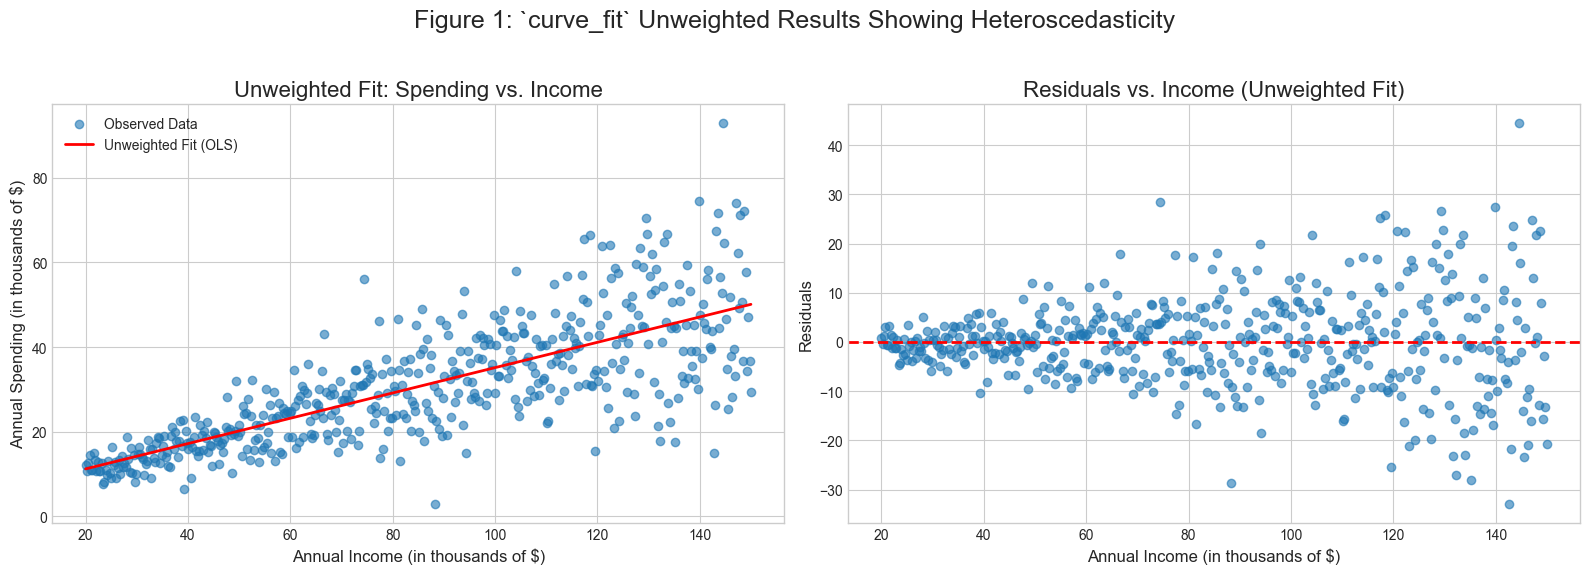

In [31]:
# --- 2. Perform an Initial "OLS" Fit using curve_fit ---
# An unweighted fit in curve_fit is equivalent to an OLS fit.

print("--- Step 1 & 2: Performing Unweighted Fit (OLS) and Analyzing Residuals ---")

# Perform the fit without providing sigma
popt_ols, pcov_ols = curve_fit(linear_model, income, observed_spending)
perr_ols = np.sqrt(np.diag(pcov_ols)) # Standard errors of the parameters

print("\nOLS Parameter Estimates:")
print(f"  Intercept: {popt_ols[0]:.4f} +/- {perr_ols[0]:.4f}")
print(f"  Slope:     {popt_ols[1]:.4f} +/- {perr_ols[1]:.4f}")
# NOTE: These standard errors are less reliable because heteroscedasticity is present.

# Calculate predictions and residuals
ols_predictions = linear_model(income, *popt_ols)
ols_residuals = observed_spending - ols_predictions

n = n_samples # Number of data points
k = len(popt_ols)  # Number of parameters

# Calculate Residual Sum of Squares (RSS)
ols_rss = np.sum(ols_residuals**2)

# Calculate Root Mean Squared Error (RMSE)
ols_rmse = np.sqrt(np.mean(ols_residuals**2))

ols_ser = np.sqrt(ols_rss / (n - k))

# Calculate R-squared
# 1. Calculate the Total Sum of Squares (TSS)
#    TSS is the sum of the squared differences between observed values and their mean.
y_mean = np.mean(observed_spending)
tss = np.sum((observed_spending - y_mean)**2)

# 2. Calculate R-squared from RSS and TSS
ols_r_squared = 1 - (ols_rss / tss)

# Adjusted R-squared calculation
# Ensure n - k is not zero or negative to avoid division by zero
if (n - k) > 0:
    ols_adjusted_r_squared = 1 - (1 - ols_r_squared) * (n - 1) / (n - k)
else:
    ols_adjusted_r_squared = np.nan # Not applicable if degrees of freedom are insufficient

print(f"Residual Sum of Squares (RSS): {ols_rss:.2f}")
print(f"Root Mean Squared Error (RMSE): {ols_rmse:.2f}")
print(f"Standard Error of the Residuals (SER): {ols_ser:.2f}")
print(f"R-squared: {ols_r_squared:.4f}")
print(f"Adjusted R-squared: {ols_adjusted_r_squared:.4f}")

# --- Plot OLS Results and Residuals ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: OLS Fit
ax1.scatter(income, observed_spending, alpha=0.6, label='Observed Data')
ax1.plot(income, ols_predictions, color='red', linewidth=2, label='Unweighted Fit (OLS)')
ax1.set_title('Unweighted Fit: Spending vs. Income', fontsize=16)
ax1.set_xlabel('Annual Income (in thousands of $)', fontsize=12)
ax1.set_ylabel('Annual Spending (in thousands of $)', fontsize=12)
ax1.legend()

# Plot 2: Residual Plot to show heteroscedasticity
ax2.scatter(income, ols_residuals, alpha=0.6)
ax2.axhline(0, color='red', linestyle='--', linewidth=2)
ax2.set_title('Residuals vs. Income (Unweighted Fit)', fontsize=16)
ax2.set_xlabel('Annual Income (in thousands of $)', fontsize=12)
ax2.set_ylabel('Residuals', fontsize=12)

plt.suptitle("Figure 1: `curve_fit` Unweighted Results Showing Heteroscedasticity", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [32]:
# --- 3. Estimate Sigma (Standard Deviation) from OLS Residuals ---
print("\n--- Step 3: Estimating Sigma from Residuals ---")
# Model the standard deviation as a linear function of income.
# We fit this model to the absolute values of the OLS residuals.
abs_ols_residuals = np.abs(ols_residuals)

# Fit a model to estimate the standard deviation
popt_var, _ = curve_fit(linear_model, income, abs_ols_residuals)

# The predictions from this fit are our estimated sigma values
estimated_sigma = linear_model(income, *popt_var)
# Ensure sigma is not negative (can happen with linear models at extremes)
estimated_sigma = np.maximum(estimated_sigma, 1e-6) 

print("Sigma for each data point has been estimated based on the residuals.")


--- Step 3: Estimating Sigma from Residuals ---
Sigma for each data point has been estimated based on the residuals.



--- Step 4: Performing Weighted Fit (WLS) with Estimated Sigma ---

WLS Parameter Estimates:
  Intercept: 4.5562 +/- 0.3097
  Slope:     0.3076 +/- 0.0064
WLS Residual Sum of Squares (RSS): 43805.61
WLS Root Mean Squared Error (RMSE): 9.36
WLS Standard Error of the Residuals (SER): 9.38
WLS R-squared: 0.5909
WLS Adjusted R-squared: 0.5901


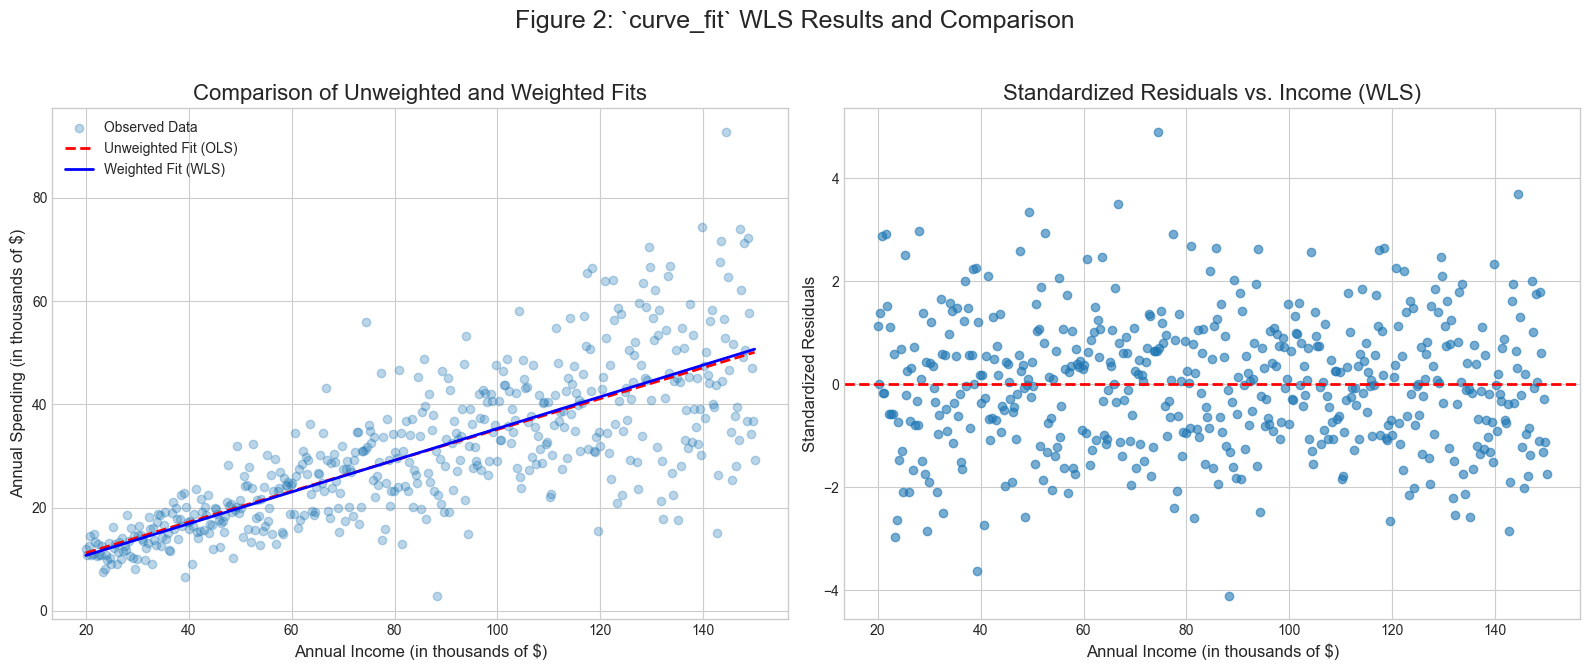

In [34]:


# --- 4. Perform the Final "WLS" Fit using curve_fit ---
print("\n--- Step 4: Performing Weighted Fit (WLS) with Estimated Sigma ---")
# Now, we pass the estimated sigma to curve_fit.
# `absolute_sigma=True` is crucial. It tells curve_fit that our sigma values are
# the absolute standard deviations, which are used to calculate weights (1/sigma**2).
# This also ensures the covariance matrix pcov is calculated correctly.
popt_wls, pcov_wls = curve_fit(linear_model, income, observed_spending,
                               sigma=estimated_sigma,
                               absolute_sigma=True)
perr_wls = np.sqrt(np.diag(pcov_wls)) # More reliable standard errors

print("\nWLS Parameter Estimates:")
print(f"  Intercept: {popt_wls[0]:.4f} +/- {perr_wls[0]:.4f}")
print(f"  Slope:     {popt_wls[1]:.4f} +/- {perr_wls[1]:.4f}")

# Calculate WLS predictions
wls_predictions = linear_model(income, *popt_wls)

# WLS Standardized Residuals
# These are the raw residuals divided by their estimated sigma.
# They should now have a constant variance (i.e., be homoscedastic).
wls_residuals = observed_spending - wls_predictions
wls_standardized_residuals = (observed_spending - wls_predictions) / estimated_sigma


# Calculate Residual Sum of Squares (RSS)
wls_rss = np.sum(wls_residuals**2)

# Calculate Root Mean Squared Error (RMSE)
wls_rmse = np.sqrt(np.mean(wls_residuals**2))

wls_ser = np.sqrt(wls_rss / (n - k))

# Calculate R-squared
# 1. Calculate the Total Sum of Squares (TSS)
#    TSS is the sum of the squared differences between observed values and their mean.
y_mean = np.mean(observed_spending)
tss = np.sum((observed_spending - y_mean)**2)

# 2. Calculate R-squared from RSS and TSS
wls_r_squared = 1 - (wls_rss / tss)

# Adjusted R-squared calculation
# Ensure n - k is not zero or negative to avoid division by zero
if (n - k) > 0:
    wls_adjusted_r_squared = 1 - (1 - wls_r_squared) * (n - 1) / (n - k)
else:
    wls_adjusted_r_squared = np.nan # Not applicable if degrees of freedom are insufficient

print(f"WLS Residual Sum of Squares (RSS): {wls_rss:.2f}")
print(f"WLS Root Mean Squared Error (RMSE): {wls_rmse:.2f}")
print(f"WLS Standard Error of the Residuals (SER): {wls_ser:.2f}")
print(f"WLS R-squared: {wls_r_squared:.4f}")
print(f"WLS Adjusted R-squared: {wls_adjusted_r_squared:.4f}")

# --- 5. Visualize and Compare OLS and WLS Results ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: Comparison of OLS and WLS fits
ax1.scatter(income, observed_spending, alpha=0.3, label='Observed Data')
ax1.plot(income, ols_predictions, color='red', linestyle='--', linewidth=2, label='Unweighted Fit (OLS)')
ax1.plot(income, wls_predictions, color='blue', linewidth=2, label='Weighted Fit (WLS)')
ax1.set_title('Comparison of Unweighted and Weighted Fits', fontsize=16)
ax1.set_xlabel('Annual Income (in thousands of $)', fontsize=12)
ax1.set_ylabel('Annual Spending (in thousands of $)', fontsize=12)
ax1.legend()

# Plot 2: WLS Standardized Residuals
# These are the raw residuals divided by their estimated sigma.
# They should now have a constant variance (i.e., be homoscedastic).
wls_standardized_residuals = (observed_spending - wls_predictions) / estimated_sigma
ax2.scatter(income, wls_standardized_residuals, alpha=0.6)
ax2.axhline(0, color='red', linestyle='--', linewidth=2)
ax2.set_title('Standardized Residuals vs. Income (WLS)', fontsize=16)
ax2.set_xlabel('Annual Income (in thousands of $)', fontsize=12)
ax2.set_ylabel('Standardized Residuals', fontsize=12)

plt.suptitle("Figure 2: `curve_fit` WLS Results and Comparison", fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()